Running Queries In Spark
---------------------------

I took the data from Twitter and performed an analysis based on the question *How frequently do people make drug references on Twitter? Which drugs are the most often referenced?*

Here's how I approached the query:
1. Filter out tweets with certain slang words that reference hard drugs. 
2. Use `map` method to store the time that the tweet was sent.
3. Append the current drug references to the main dataframe.
4. Query the temporary table to return the most recent drug references trending, and show to the console.


#### Import the relevant modules

In [1]:
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row,SQLContext, SparkSession
import sys
import requests
import time

#### Set some constants, initialize Spark, and then open the socket with the remote host.

In [2]:
TCP_REMOTE_HOST = "data_server"
TCP_PORT = 9009

conf = SparkConf()
conf.setAppName("TwitterStreamApp")

sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")

ssc = StreamingContext(sc, 2)

ssc.checkpoint("checkpoint_TwitterApp")

dataStream = ssc.socketTextStream(TCP_REMOTE_HOST, TCP_PORT)

#### We now create some helper functions to allow Spark to maintain our running count.

In [3]:
def aggregate_tags_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

def getSparkSessionInstance(sparkConf):
    if ("sparkSessionSingletonInstance" not in globals()):
        globals()["sparkSessionSingletonInstance"] = SparkSession \
            .builder \
            .config(conf=sparkConf) \
            .getOrCreate()
    return globals()["sparkSessionSingletonInstance"]

def process_rdd(time, rdd):
    print(f"----------- {str(time)} -----------")
    try:
        spark = getSparkSessionInstance(rdd.context.getConf())
        
        row_rdd = rdd.map(lambda w: Row(drug_reference=w[0], time=w[1]))
        
        drug_slang_df = spark.createDataFrame(row_rdd)
        
        drug_slang_df.registerTempTable("drug_slang")
        
        drug_slang_df.write.mode('append').csv('Drug_Slang1.csv')
        
        drug_slang_counts_df = spark.sql(
            "select drug_reference, time from drug_slang order by time asc limit 300")
        drug_slang_counts_df.show()

    except Exception as e:
        e = sys.exc_info()[1]
        print(f"Error: {e}")

#### Finally, we assign our primary workflow that will utilize the above functions.

In [4]:
from pyspark.ml.feature import StopWordsRemover

drug_slang = dataStream.filter(lambda w: ("china white" in w) or ("white horse" in w) or ("brown sugar" in w) or ("black stuff" in w) or ("golden girls" in w) or ("syrup" in w) or ("purple drank" in w) or ("Watsons" in w) or ("oxy" in w) or ("king ivory" in w) or ("tango and cash" in w) or ("murder eight" in w) or ("perc-a-pop" in w) or ("heroin" in w) or ("codeine" in w) or ("vikes" in w) or ("benzo" in w)).map(lambda x: (x, time.time()))


tags_totals = drug_slang.updateStateByKey(aggregate_tags_count)

tags_totals.foreachRDD(process_rdd)

ssc.start()

ssc.awaitTermination()



----------- 2019-02-08 19:49:14 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:16 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:18 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:20 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:22 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:24 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:26 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:28 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:30 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:32 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:34 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:36 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:38 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:40 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:42 -----------
Error: RDD is empty
----------- 2019-02-08 19:49:44 --------

----------- 2019-02-08 19:51:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:51:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:51:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:51:16 -----------
+--------------------+-------

----------- 2019-02-08 19:52:04 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:52:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:52:08 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:52:10 -----------
+--------------------+-------

----------- 2019-02-08 19:52:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:53:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:53:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:53:04 -----------
+--------------------+-------

----------- 2019-02-08 19:53:52 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:53:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:53:56 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:53:58 -----------
+--------------------+-------

----------- 2019-02-08 19:54:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:54:48 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:54:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:54:52 -----------
+--------------------+-------

----------- 2019-02-08 19:55:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:55:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:55:44 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:55:46 -----------
+--------------------+-------

----------- 2019-02-08 19:56:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:56:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:56:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:56:40 -----------
+--------------------+-------

----------- 2019-02-08 19:57:28 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:57:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:57:32 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:57:34 -----------
+--------------------+-------

----------- 2019-02-08 19:58:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:58:24 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:58:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:58:28 -----------
+--------------------+-------

----------- 2019-02-08 19:59:16 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:59:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:59:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 19:59:22 -----------
+--------------------+-------

----------- 2019-02-08 20:00:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
+--------------------+--------------------+

----------- 2019-02-08 20:00:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------------------+

----------- 2019-02-08 20:00:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------

----------- 2019-02-08 20:00:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------------------+

----------- 2019-02-08 20:01:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------------------+

----------- 2019-02-08 20:01:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.5496

----------- 2019-02-08 20:01:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------------------+

----------- 2019-02-08 20:01:48 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------------------+

----------- 2019-02-08 20:01:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.5496

----------- 2019-02-08 20:02:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------------------+

----------- 2019-02-08 20:02:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
+--------------------+--------------------+

----------- 2019-02-08 20:02:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.5496

----------- 2019-02-08 20:03:16 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:03:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:03:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.549655

----------- 2019-02-08 20:03:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:04:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:04:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.549655

----------- 2019-02-08 20:04:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:04:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:04:44 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.549655

----------- 2019-02-08 20:05:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:05:24 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
+--------------------+--------------------+

----------- 2019-02-08 20:05:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.549655

----------- 2019-02-08 20:06:04 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:06:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:06:08 -----------
+--------------------+--------------------+
|      drug_reference|        

----------- 2019-02-08 20:06:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:06:44 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:06:46 -----------
+--------------------+--------------------+
|      drug_reference|        

----------- 2019-02-08 20:07:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:07:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:07:24 -----------
+--------------------+--------------------+
|      drug_reference|        

----------- 2019-02-08 20:07:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:08:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:08:02 -----------
+--------------------+--------------------+
|      drug_reference|        

----------- 2019-02-08 20:08:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:08:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:08:40 -----------
+--------------------+--------------------+
|      drug_reference|        

----------- 2019-02-08 20:09:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:09:16 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:09:18 -----------
+--------------------+--------------------+
|      drug_reference|        

----------- 2019-02-08 20:09:52 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:09:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:09:56 -----------
+--------------------+--------------------+
|      drug_reference|        

----------- 2019-02-08 20:10:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
+--------------------+--------------------+

----------- 2019-02-08 20:10:32 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
+--------------------+--------------------+

----------- 2019-02-08 20:10:34 -----------
+--------------------+--------

----------- 2019-02-08 20:11:04 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
+--------------------+--------------------+

----------- 2019-02-08 20:11:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
+--------------------+--------------------+

----------- 2019-02-08 20:11:0

----------- 2019-02-08 20:11:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
+--------------------+--------------------+

----------- 2019-02-08 20:11:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
+--------------------+--------------------+

----------- 2019-02-08 20:11:4

----------- 2019-02-08 20:12:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
+--------------------+--------------------+

----------- 2019-02-08 20:12:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567

----------- 2019-02-08 20:12:44 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
+--------------------+--------------------+

----------- 2019-02-08 20:12:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567

----------- 2019-02-08 20:13:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
+--------------------+--------------------+

----------- 2019-02-08 20:13:16 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566

----------- 2019-02-08 20:13:44 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
+--------------------+--------------------+

----------- 2019-02-08 20:13:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566

----------- 2019-02-08 20:14:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
+--------------------+--------------------+

----------- 2019-02-08 20:14:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563

----------- 2019-02-08 20:14:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
+--------------------+--------------------+

----------- 2019-02-08 20:14:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563

----------- 2019-02-08 20:15:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:15:08 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:15:32 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:15:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:15:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:16:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:16:24 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:16:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:16:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:16:52 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:17:16 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:17:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:17:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:17:44 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:18:08 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:18:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:18:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:18:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:19:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:19:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:19:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:19:28 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:19:52 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:19:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:20:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:20:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:20:44 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:20:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:21:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:21:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:21:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:21:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:22:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:22:04 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:22:28 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:22:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:22:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:22:56 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:23:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:23:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:23:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:23:48 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:24:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
+--------------------+--------------------+

----------- 2019-02-08 20:24:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561

----------- 2019-02-08 20:24:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
+--------------------+--------------------+

----------- 2019-02-08 20:24:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965

----------- 2019-02-08 20:25:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
+--------------------+--------------------+

----------- 2019-02-08 20:25:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965

----------- 2019-02-08 20:25:24 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
+--------------------+--------------------+

----------- 2019-02-08 20:25:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965

----------- 2019-02-08 20:25:48 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
+--------------------+--------------------+

----------- 2019-02-08 20:25:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965

----------- 2019-02-08 20:26:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
+--------------------+--------------------+

----------- 2019-02-08 20:26:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965

----------- 2019-02-08 20:26:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
+--------------------+--------------------+

----------- 2019-02-08 20:26:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554

----------- 2019-02-08 20:26:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
+--------------------+--------------------+

----------- 2019-02-08 20:27:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554

----------- 2019-02-08 20:27:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
+--------------------+--------------------+

----------- 2019-02-08 20:27:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554

----------- 2019-02-08 20:27:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:27:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:28:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:28:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:28:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:28:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:28:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:28:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:29:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:29:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:29:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:29:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:29:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:29:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:30:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
+--------------------+--------------------+

----------- 2019-02-08 20:30:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+---------

----------- 2019-02-08 20:30:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
+--------------------+--------------------+

----------- 2019-02-08 20:30:22 -----------
+--------------------+--------------------+
|      drug_reference|         

----------- 2019-02-08 20:30:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
+--------------------+--------------------+

----------- 2019-02-08 20:30:42 -----------
+--------------------+--------------------+
|      drug_reference|         

----------- 2019-02-08 20:31:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
+--------------------+--------------------+

----------- 2019-02-08 20:31:02 -----------
+--------------------+--------------------+
|      drug_reference|         

----------- 2019-02-08 20:31:20 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
+--------------------+--------------------+

----------- 2019-02-08 20:31:22 -----------
+--------------------+--------------------+
|      drug_reference|         

----------- 2019-02-08 20:31:40 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
+--------------------+--------------------+

----------- 2019-02-08 20:31:42 -----------
+--------------------+--------------------+
|      drug_reference|         

----------- 2019-02-08 20:32:00 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
+--------------------+--------------------+

----------- 2019-02-08 20:32:02 -----------
+--------------------+---------

----------- 2019-02-08 20:32:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
+--------------------+--------------------+

----------- 2019-02-08 20:32:20 -----------
+--------------------+---------

----------- 2019-02-08 20:32:36 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
+--------------------+--------------------+

----------- 2019-02-08 20:32:38 -----------
+--------------------+---------

----------- 2019-02-08 20:32:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
+--------------------+--------------------+

----------- 2019-02-08 20:32:56

----------- 2019-02-08 20:33:12 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
+--------------------+--------------------+

----------- 2019-02-08 20:33:14

----------- 2019-02-08 20:33:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
+--------------------+----------

----------- 2019-02-08 20:33:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:34:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:34:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:34:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:34:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:35:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:35:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:35:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:35:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:36:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:36:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:36:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:36:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:37:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:37:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:37:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:38:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:38:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:38:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:38:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:39:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:39:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:39:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:39:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:40:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:40:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:40:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:40:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:41:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:41:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:41:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:42:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:42:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:42:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:42:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:43:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:43:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:43:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:43:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:44:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:44:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:44:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:44:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:45:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:45:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:45:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:46:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:46:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:46:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:46:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:47:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:47:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:47:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:47:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:48:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:48:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:48:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:48:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:49:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:49:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:49:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:50:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:50:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:50:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:50:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:51:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:51:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:51:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:51:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:52:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:52:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:52:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:52:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:53:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:53:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:53:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:54:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:54:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:54:34 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:54:50 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:55:06 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:55:22 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:55:38 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:55:54 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:56:10 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:56:26 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:56:42 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:56:58 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:57:14 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:57:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:57:46 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:58:02 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

----------- 2019-02-08 20:58:18 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

KeyboardInterrupt: 

----------- 2019-02-08 20:58:30 -----------
+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.5496580181

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

In [6]:
ssc.stop()



+--------------------+--------------------+
|      drug_reference|                time|
+--------------------+--------------------+
|You will now be r...|1.5496554242273922E9|
|Here is a group p...|1.5496554681554475E9|
|This is great, gr...|  1.54965601226684E9|
|Free Sakte on Fam...|1.5496561601869922E9|
|#poetry #winterpo...|1.5496563641547182E9|
|#pinkaesthetic #g...|1.5496566321591249E9|
|IT HAS BEEN DEBUN...|1.5496567281589177E9|
|All this extra “s...|1.5496567761510868E9|
|Either I’m your t...| 1.549656844159252E9|
|*Closin… https://...|1.5496568962362306E9|
|#PortraitPerfecti...|1.5496574642082112E9|
|This… https://t.c...| 1.549657588272498E9|
|Pop-Up CCSD Famil...|1.5496576342041636E9|
|Everything in the...|1.5496576421559837E9|
|Dm ladies!! Place...|1.5496578102564094E9|
|Frieza saga shitt...|1.5496579101561458E9|
|AS IT IS AN… http...|1.5496579621923351E9|
|Come to: learn ho...|1.5496579941840017E9|
|🏀 🐻 👌 #ItsBrui...| 1.549658018180425E9|
|Me: bro actually ...| 1.5496580602

In [2]:
import pandas as pd

In [3]:
!pwd


/home/ds/notebooks


In [4]:
df = pd.read_csv("alldrugs9.csv", error_bad_lines=False, header=None)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
df.shape

(121735, 6)

In [6]:
df.head(10)

0  \
0  Free Sakte on Family Day at the Pickering Recr...   
1  Pop-Up CCSD Family Engagement Day! Join CCSD F...   
2  Free Sakte on Family Day at the Pickering Recr...   
3  Pop-Up CCSD Family Engagement Day! Join CCSD F...   
4  #AdultingAndStuff@OjThok_14 @WarolG So this ai...   
5  #tshirt #tshirts #sweatshirt #hoodie #newyorkc...   
6  Free Sakte on Family Day at the Pickering Recr...   
7  Pop-Up CCSD Family Engagement Day! Join CCSD F...   
8  #AdultingAndStuff@OjThok_14 @WarolG So this ai...   
9  #tshirt #tshirts #sweatshirt #hoodie #newyorkc...   

                                                   1  \
0   then look for… https://t.co/NyjMZPa7cW@ATLSAH...   
1                               1.5496576342041636E9   
2   then look for… https://t.co/NyjMZPa7cW@ATLSAH...   
3                               1.5496576342041636E9   
4                               1.5496583021801414E9   
5                                1.549658926240173E9   
6   then look for… https://t.co/NyjMZPa7cW@ATLSAH...   
7                               1.5496576342041636E9   
8                               1.5496583021801414E9   
9                                1.549658926240173E9   

                                                   2  \
0   Software Engineer in Test\"? What did you lik...   
1                                                NaN   
2   Software Engineer in Test\"? What did you lik...   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6   Software Engineer in Test\"? What did you lik...   
7                                                NaN   
8                                                NaN   
9                                                NaN   

                                                   3  \
0   MOI feel attacked 😂😂😂😂Want to work at Ulta Be...   
1                                                NaN   
2   MOI feel attacked 😂😂😂😂Want to work at Ulta Be...   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6   MOI feel attacked 😂😂😂😂Want to work at Ulta Be...   
7                                                NaN   
8                                                NaN   
9                                                NaN   

                                                   4             5  
0   MI! Click the link in our bio for details on ...  1.549656e+09  
1                                                NaN           NaN  
2   MI! Click the link in our bio for details on ...  1.549656e+09  
3                                                NaN           NaN  
4                                                NaN           NaN  
5                                                NaN           NaN  
6   MI! Click the link in our bio for details on ...  1.549656e+09  
7                                                NaN           NaN  
8                                                NaN           NaN  
9                                                NaN           NaN

In [7]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [8]:
len(df.iloc[:, 0].unique())

17

In [9]:
df = df.drop_duplicates()

In [10]:
df.shape

(17, 6)

In [12]:
df.iloc[0]

0    Free Sakte on Family Day at the Pickering Recr...
1     then look for… https://t.co/NyjMZPa7cW@ATLSAH...
2     Software Engineer in Test\"? What did you lik...
3     MOI feel attacked 😂😂😂😂Want to work at Ulta Be...
4     MI! Click the link in our bio for details on ...
5                                          1.54966e+09
Name: 0, dtype: object

In [32]:
def Drug_Referenced(t):
    #for t in df.iloc[:, 0]:
    if ("china white" in t) or ("white horse" in t) or ("brown sugar" in t) or ("black stuff" in t) or ("golden girls" in t) or ("heroin" in t):
        return "Heroin"
    if ("syrup" in t) or ("purple drank" in t) or ("codeine" in t):
        return "Codeine"
    if ("Watsons" in t) or ("vikes" in t):
        return "Vicodin"
    if ("tango and cash" in t) or ("king ivory" in t) or ("murder eight" in t) or ("perc-a-pop" in t):
        return "Fentanyl"
    if ("oxy" in t):
        return "OxyContin"
    if ("benzo" in t):
        return "Benzodiazepines"
    else:
        return "None"
    

In [33]:
df["Drug_Referenced"] = df.iloc[:, 0].apply(Drug_Referenced)

In [34]:
df["Drug_Referenced"].value_counts()

OxyContin    10
Codeine       3
None          2
Heroin        2
Name: Drug_Referenced, dtype: int64

In [36]:
df

0  \
0      Free Sakte on Family Day at the Pickering Recr...   
1      Pop-Up CCSD Family Engagement Day! Join CCSD F...   
4      #AdultingAndStuff@OjThok_14 @WarolG So this ai...   
5      #tshirt #tshirts #sweatshirt #hoodie #newyorkc...   
28093  *Closin… https://t.co/S4GNYZBCch@KidusAssefa3 ...   
28095  AS IT IS AN… https://t.co/7i6hzcM5IpIt took me...   
28096  Probably that sweating.TEST_GEO_Hierarchy: 4bb...   
48995  #poetry #winterpoem #poem… https://t.co/4ERRPX...   
56714  This is great, great news.It will all get bett...   
64609  #Catlife #CatMom #CatLove @ Walterhill, Tennes...   
71126  You will now be returned to your normal broadc...   
71127  All this extra “special” water is a business m...   
71130  Frieza saga shitting on this@AIIAmericanGirI @...   
93774  IT HAS BEEN DEBUNKED and PROVEN—EVEN BY DATES—...   
93775  This… https://t.co/ethEed1tQd@BarackObama We m...   
93778  🏀 🐻 👌 #ItsBruinTime https://t.co/h7qJKR6FdBGre...   
93779  #constructions #civilconstruction #glasscompan...   

                                                       1  \
0       then look for… https://t.co/NyjMZPa7cW@ATLSAH...   
1                                   1.5496576342041636E9   
4                                   1.5496583021801414E9   
5                                    1.549658926240173E9   
28093                               1.5496568962362306E9   
28095                               1.5496579621923351E9   
28096   CT! Click the link in our bio for details on ...   
48995   through 2.5 years of my bosses and coworkers ...   
56714                                 1.54965601226684E9   
64609                               1.5496587682121816E9   
71126                               1.5496554242273922E9   
71127                               1.5496567761510868E9   
71130                               1.5496579101561458E9   
93774                               1.5496567281589177E9   
93775                                              \"Nah   
93778                                1.549658018180425E9   
93779                               1.5496589541441782E9   

                                                       2  \
0       Software Engineer in Test\"? What did you lik...   
1                                                    NaN   
4                                                    NaN   
5                                                    NaN   
28093                                                NaN   
28095                                                NaN   
28096   VA. Follow us and turn on mobile alerts to he...   
48995   NY https://t.co/a8pRsDrKv3@NeverLostout North...   
56714                                                NaN   
64609                                                NaN   
71126                                                NaN   
71127                                                NaN   
71130                                                NaN   
93774                                                NaN   
93775   I want all 'em.\" https://t.co/zWpwHv7q5pAstr...   
93778                                                NaN   
93779                                                NaN   

                                                       3  \
0       MOI feel attacked 😂😂😂😂Want to work at Ulta Be...   
1                                                    NaN   
4                                                    NaN   
5                                                    NaN   
28093                                                NaN   
28095                                                NaN   
28096   may I share with our viewers on @GMA and all ...   
48995                               1.5496563641547182E9   
56714                                                NaN   
64609                                                NaN   
71126                                                NaN   
71127                                                NaN   
71130                           

In [24]:
df.iloc[0,0]

'Free Sakte on Family Day at the Pickering Recreation Complex.  Bring your own sk… https://t.co/TYaOA5sYwMA 4 yr old with cocaine in their system, an 11 yr old has to be given narcan because of a heroin overdose. What is this world coming too?😪😡@brookejanay__ I feel like it should be😭then again .. hair stylists be out here with their kitchens fucked up so idk🤔💃🏾🕴🏾black history month, forever. @lucillebignom @ Gold Sounds https://t.co/HAtIdmHeMe@VolRecruiting98 Hate that it happened to a VFL but they maybe making room for a better on field coach and recruite… https://t.co/UQ644V2uyQthat one hr nap I just had was magicalWendy\'s bugging, charging 4.95 for a 444i’m getting a snake and i need help choosing a name soooo\U0001f92aThis job is now open at Hoist &amp; Crane Service Group in Indianapolis, IN. Follow us and turn on mobile alerts to hea… https://t.co/7bHRNgWgbELooking good in red! Woof!Student labeling the ams_neve VR60 Console for a class recording session in Studio A #omega #stu

In [45]:
df.iloc[0,1]

' then look for… https://t.co/NyjMZPa7cW@ATLSAHM Owls!@tdb325 And no one is going to change their opinions. I’ll just tell them to do them and I’ll do me. No point in arguingHave you ever had a role like \\"Sr. Engineer'

In [47]:
df.iloc[0,2]

' Software Engineer in Test\\"? What did you like most about that job? #ProjectMgmt #OFallon'

In [48]:
df.iloc[0,3]

" MOI feel attacked 😂😂😂😂Want to work at Ulta Beauty? We're hiring in #FarmingtonHills"

In [50]:
df.iloc[0,1] = df.iloc[0,5]

In [51]:
df.head()

0  \
0      Free Sakte on Family Day at the Pickering Recr...   
1      Pop-Up CCSD Family Engagement Day! Join CCSD F...   
4      #AdultingAndStuff@OjThok_14 @WarolG So this ai...   
5      #tshirt #tshirts #sweatshirt #hoodie #newyorkc...   
28093  *Closin… https://t.co/S4GNYZBCch@KidusAssefa3 ...   

                          1  \
0               1.54966e+09   
1      1.5496576342041636E9   
4      1.5496583021801414E9   
5       1.549658926240173E9   
28093  1.5496568962362306E9   

                                                       2  \
0       Software Engineer in Test\"? What did you lik...   
1                                                    NaN   
4                                                    NaN   
5                                                    NaN   
28093                                                NaN   

                                                       3  \
0       MOI feel attacked 😂😂😂😂Want to work at Ulta Be...   
1                                                    NaN   
4                                                    NaN   
5                                                    NaN   
28093                                                NaN   

                                                       4             5  \
0       MI! Click the link in our bio for details on ...  1.549656e+09   
1                                                    NaN           NaN   
4                                                    NaN           NaN   
5                                                    NaN           NaN   
28093                                                NaN           NaN   

      Drug_Referenced  
0              Heroin  
1             Codeine  
4           OxyContin  
5           OxyContin  
28093       OxyContin

In [52]:
df.iloc[6,1] = df.iloc[6,4]

In [53]:
df.iloc[7,1] = df.iloc[7,3]

In [55]:
df.iloc[14,1] = df.iloc[14,3]

In [56]:
df

0  \
0      Free Sakte on Family Day at the Pickering Recr...   
1      Pop-Up CCSD Family Engagement Day! Join CCSD F...   
4      #AdultingAndStuff@OjThok_14 @WarolG So this ai...   
5      #tshirt #tshirts #sweatshirt #hoodie #newyorkc...   
28093  *Closin… https://t.co/S4GNYZBCch@KidusAssefa3 ...   
28095  AS IT IS AN… https://t.co/7i6hzcM5IpIt took me...   
28096  Probably that sweating.TEST_GEO_Hierarchy: 4bb...   
48995  #poetry #winterpoem #poem… https://t.co/4ERRPX...   
56714  This is great, great news.It will all get bett...   
64609  #Catlife #CatMom #CatLove @ Walterhill, Tennes...   
71126  You will now be returned to your normal broadc...   
71127  All this extra “special” water is a business m...   
71130  Frieza saga shitting on this@AIIAmericanGirI @...   
93774  IT HAS BEEN DEBUNKED and PROVEN—EVEN BY DATES—...   
93775  This… https://t.co/ethEed1tQd@BarackObama We m...   
93778  🏀 🐻 👌 #ItsBruinTime https://t.co/h7qJKR6FdBGre...   
93779  #constructions #civilconstruction #glasscompan...   

                          1  \
0               1.54966e+09   
1      1.5496576342041636E9   
4      1.5496583021801414E9   
5       1.549658926240173E9   
28093  1.5496568962362306E9   
28095  1.5496579621923351E9   
28096  1.5496587441962037E9   
48995  1.5496563641547182E9   
56714    1.54965601226684E9   
64609  1.5496587682121816E9   
71126  1.5496554242273922E9   
71127  1.5496567761510868E9   
71130  1.5496579101561458E9   
93774  1.5496567281589177E9   
93775   1.549657588272498E9   
93778   1.549658018180425E9   
93779  1.5496589541441782E9   

                                                       2  \
0       Software Engineer in Test\"? What did you lik...   
1                                                    NaN   
4                                                    NaN   
5                                                    NaN   
28093                                                NaN   
28095                                                NaN   
28096   VA. Follow us and turn on mobile alerts to he...   
48995   NY https://t.co/a8pRsDrKv3@NeverLostout North...   
56714                                                NaN   
64609                                                NaN   
71126                                                NaN   
71127                                                NaN   
71130                                                NaN   
93774                                                NaN   
93775   I want all 'em.\" https://t.co/zWpwHv7q5pAstr...   
93778                                                NaN   
93779                                                NaN   

                                                       3  \
0       MOI feel attacked 😂😂😂😂Want to work at Ulta Be...   
1                                                    NaN   
4                                                    NaN   
5                                                    NaN   
28093                                                NaN   
28095                                                NaN   
28096   may I share with our viewers on @GMA and all ...   
48995                               1.5496563641547182E9   
56714                                                NaN   
64609                                                NaN   
71126                                                NaN   
71127                                                NaN   
71130                                                NaN   
93774                                                NaN   
93775                                1.549657588272498E9   
93778                                                NaN   
93779                                                NaN   

                                                       4             5  \
0       MI! Click the link in our bio for details on ...  1.549656e+09   
1                                                    NaN           NaN   
4                              

In [58]:
df = df.drop([2, 3, 4, 5], axis=1)

In [59]:
df

0  \
0      Free Sakte on Family Day at the Pickering Recr...   
1      Pop-Up CCSD Family Engagement Day! Join CCSD F...   
4      #AdultingAndStuff@OjThok_14 @WarolG So this ai...   
5      #tshirt #tshirts #sweatshirt #hoodie #newyorkc...   
28093  *Closin… https://t.co/S4GNYZBCch@KidusAssefa3 ...   
28095  AS IT IS AN… https://t.co/7i6hzcM5IpIt took me...   
28096  Probably that sweating.TEST_GEO_Hierarchy: 4bb...   
48995  #poetry #winterpoem #poem… https://t.co/4ERRPX...   
56714  This is great, great news.It will all get bett...   
64609  #Catlife #CatMom #CatLove @ Walterhill, Tennes...   
71126  You will now be returned to your normal broadc...   
71127  All this extra “special” water is a business m...   
71130  Frieza saga shitting on this@AIIAmericanGirI @...   
93774  IT HAS BEEN DEBUNKED and PROVEN—EVEN BY DATES—...   
93775  This… https://t.co/ethEed1tQd@BarackObama We m...   
93778  🏀 🐻 👌 #ItsBruinTime https://t.co/h7qJKR6FdBGre...   
93779  #constructions #civilconstruction #glasscompan...   

                          1 Drug_Referenced  
0               1.54966e+09          Heroin  
1      1.5496576342041636E9         Codeine  
4      1.5496583021801414E9       OxyContin  
5       1.549658926240173E9       OxyContin  
28093  1.5496568962362306E9       OxyContin  
28095  1.5496579621923351E9         Codeine  
28096  1.5496587441962037E9            None  
48995  1.5496563641547182E9            None  
56714    1.54965601226684E9         Codeine  
64609  1.5496587682121816E9       OxyContin  
71126  1.5496554242273922E9          Heroin  
71127  1.5496567761510868E9       OxyContin  
71130  1.5496579101561458E9       OxyContin  
93774  1.5496567281589177E9       OxyContin  
93775   1.549657588272498E9       OxyContin  
93778   1.549658018180425E9       OxyContin  
93779  1.5496589541441782E9       OxyContin

In [25]:
df.iloc[1,0]

'Pop-Up CCSD Family Engagement Day! Join CCSD FACES @CCSDontheMove this Sat… https://t.co/PJa476Uo6zThe humidity makes you a better athlete@colbeyyy Boring and longlmfao yo the fuckery of nyc is like no other.Drug addiction is a monster. It makes me sad to see people that seem to be doing great are only hiding a bigger mon… https://t.co/yCspCqGZpmSo pretty but so messy 🤧Fig &amp; Honey Martini 🍸: @docporters vodka, honey 🍯 simple syrup, fig purée, &amp; fresh squeezed lemon 🍋.'

In [26]:
df.iloc[2,0]

'#AdultingAndStuff@OjThok_14 @WarolG So this ain’t ya Valentine’s Day ?We are kicking off the first session of the LVAIC Facing Higher Education’s Future series with a presentation on To… https://t.co/ThrDlBspbU@QueenMab87 @piratefoxy @5Athena5 @barackfan1 @BlueSteelDC @Cakedaddy4ever @RyanVanHorne @GedesBru @Cheryllynn512… https://t.co/CeNXA6ZDIL@KamalaHarris Guess this explains the gop tax scam where people are getting less on tax refund or none at allBest news of the day!@JgL3x13 @SlanderOfficial @AndieObregon13 @CJWitmer_ OMG I love you I can’t wait to experience this with you@ActingWhitaker mentioned at least once that he enjoyed testifying before the DEMS on the House Judiciary Committee… https://t.co/M27EbENISq@Dannicus523 This is the inverse of 2013 and I am FURIOUS@FoxBergan Thanks Bergan! Happy Birthday to you as well, and enjoy your day!@NickisKCING wait, thats out?!While eating my food son. https://t.co/PJoub2B5yBEverybody tired lmao@mitchel_ames @Phillycat @RossGinsberg @R

In [37]:
df.iloc[3,0]

"#tshirt #tshirts #sweatshirt #hoodie #newyorkcity #newyorkcity… https://t.co/5EaoANwAjX@RochieWBZ Another clown commissioner... Let’s get @stoolpresidente on him@MerrickWarfield @RyanAFournier Trump said ISIS defeated, they're not. He told us North Korea was not building nucl… https://t.co/lJotQbJKOh@NG1951 @paula_barrocas @Goofyfan_Chuck @Kokomothegreat @realposhpenguin And WE think their time is OVER‼️🤓  🚫💩‼️When it’s her turn@MxPraxisPhanes Me too! That's possibly why NONE of it makes sense to me. But, great game nonetheless. Gonna go thr… https://t.co/vMkbKRL7sc@bakedupco Such a dope nightCongrats @kledford2323 , you deserve this award@QueenMab87 @piratefoxy @5Athena5 @barackfan1 @BlueSteelDC @Cakedaddy4ever @RyanVanHorne @GedesBru @Cheryllynn512… https://t.co/mZlnkyZQF3I believe you are correct!@Mickfllyyy @Ravealation yes! you?Keep in mind , he was tall , tattoos, waves , pretty smile . He was my college today (idk why bc i never seen him b… https://t.co/FvnSPlkJ5aTaking a coach

In [38]:
df.iloc[4,0]

"*Closin… https://t.co/S4GNYZBCch@KidusAssefa3 @mitchellvii Okay and too much C02 is bad for the environment. There’s a balance. You need oxygen to… https://t.co/CcoK20gNX8@beyonces_hoe @joeblow745 No...she's not a very good singer. Yeah, she's successful...but so is the Kartrashians TV… https://t.co/PD36Oczx9iHadda Make Sure Yuh Drop Him Home 😅@stephaniee_mm You look great girl! Go you!!  ♥️✨💖@stephenasmith c’mon now 😑 I’m always on your side but this right here is blasphemyWhere does all the water go that #whitaker is drinking? Mounth gets dry when you lie. When asked about… https://t.co/qhLVkhrXns@ShowUrSelf1 @MyWildWays1 if your doing that she is dead to me“Who’s thotiana and why do you keep asking her to bust down” -MomIL never throw party's or DJ @ No club concerts or venues &amp; I never ask to speak to noone of this subject or topic… https://t.co/zujCHfJ6vHRan out designed &amp; printed interim cards to carry @PrentisLiterary until the 2019, ones arrive. These subs were spe… ht

In [39]:
df.iloc[5,0]

'AS IT IS AN… https://t.co/7i6hzcM5IpIt took me 9 months to get caught up on one piece but ~600 episodes later I got to episode 871. I fr enjoyed every… https://t.co/3lG6dNDwFJMy hours this week is some shit🙄@ELHAEmusic - Hennessy 🔥Latest PR: SBOE #ESSATaskForce continues work on final recommendations Feb. 12 https://t.co/DMz8bzn40N via @Granicus https://t.co/qrYZyOGeZ4You’re not alone on that. Lots of people are concerned about Cristian Apache’s bat. Mostly people who aren’t baseba… https://t.co/IdHvzoSWZVTuff💪🏾🔥@fordnation Who have you empowered because no one is agreeing with this. Stop using big words you don’t understand #AutismDoesNotEndAtFORD@ChadGraff Tried to be optimistic Rask would bring something to the wild unfortunately he’s been awful, slow and pl… https://t.co/1SyIFSSSJf@BJLAFLARE7 only one@PeggyShag Great job Peggy.@StephenWalters Oh wow!  He was amazing.. such a great loss!  RIP Mr. Finney❤️🙏🏻. Love and prayers to his friends and family 😪😪You’re a nasty niggaSingle ge

In [40]:
df.iloc[6,0]

'Probably that sweating.TEST_GEO_Hierarchy: 4bbb5c45-5d2f-4c89-9a4b-9873a4ad98b1Hiring hairstylist manicurist Greenbelt college Park md.must have some following call 3019809200My baby needs bigger baskets for her towels.@RepJayapal Props to you ... for your acting skills! #WhitakerHearing #WhitakerLooking to score a job at Rogers? You\'re in luck. Click the link in our bio for the job description and information… https://t.co/dX6NcF4oNO@woodbrid5 @VexingVixxen Sound like good advice Vix. Sometime we all just need to stay in our lanes. https://t.co/5hFVtEKCAVAnyone remember these dolls? For some reason, the song from the commercial popped in my head today lol @ Our Home https://t.co/t5qbP1stSoDonald Belovich of @StikemanElliott says there are so many opportunities and so many things not yet understood in t… https://t.co/pFtRqrczDqDon\'t submit then quit. Apply for jobs like \\Campus - Undergraduate - Portfolio Monitoring Analyst 1 -...\\" at U.S.… https://t.co/mBOsGxvaewMaking more stup

In [44]:
import time

time.strftime("%H:%M:%S", time.gmtime(1.5496587441962037E9))



'20:45:44'

In [60]:
df.columns = ["Tweet", "Time", "Drug_Referenced"]

In [61]:
df.head()

Tweet  \
0      Free Sakte on Family Day at the Pickering Recr...   
1      Pop-Up CCSD Family Engagement Day! Join CCSD F...   
4      #AdultingAndStuff@OjThok_14 @WarolG So this ai...   
5      #tshirt #tshirts #sweatshirt #hoodie #newyorkc...   
28093  *Closin… https://t.co/S4GNYZBCch@KidusAssefa3 ...   

                       Time Drug_Referenced  
0               1.54966e+09          Heroin  
1      1.5496576342041636E9         Codeine  
4      1.5496583021801414E9       OxyContin  
5       1.549658926240173E9       OxyContin  
28093  1.5496568962362306E9       OxyContin

In [66]:
df.Time = pd.to_numeric(df.Time)




In [67]:
df.dtypes

Tweet               object
Time               float64
Drug_Referenced     object
dtype: object

In [76]:
df["Time"][0]

1549656160.1869922

In [79]:
def sec_to_time(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [80]:
df["Clock_Time"] = df["Time"].apply(sec_to_time)



In [81]:
df.head()

Tweet          Time  \
0      Free Sakte on Family Day at the Pickering Recr...  1.549656e+09   
1      Pop-Up CCSD Family Engagement Day! Join CCSD F...  1.549658e+09   
4      #AdultingAndStuff@OjThok_14 @WarolG So this ai...  1.549658e+09   
5      #tshirt #tshirts #sweatshirt #hoodie #newyorkc...  1.549659e+09   
28093  *Closin… https://t.co/S4GNYZBCch@KidusAssefa3 ...  1.549657e+09   

      Drug_Referenced Clock_Time  
0              Heroin   20:02:40  
1             Codeine   20:27:14  
4           OxyContin   20:38:22  
5           OxyContin   20:48:46  
28093       OxyContin   20:14:56

In [85]:
df["Drug_Referenced"].value_counts()

OxyContin    10
Codeine       3
None          2
Heroin        2
Name: Drug_Referenced, dtype: int64

In [89]:
import matplotlib.pyplot as plt
% matplotlib inline

Text(0.5,1,'Number of Alleged Drug References Tweeted in One Hour')

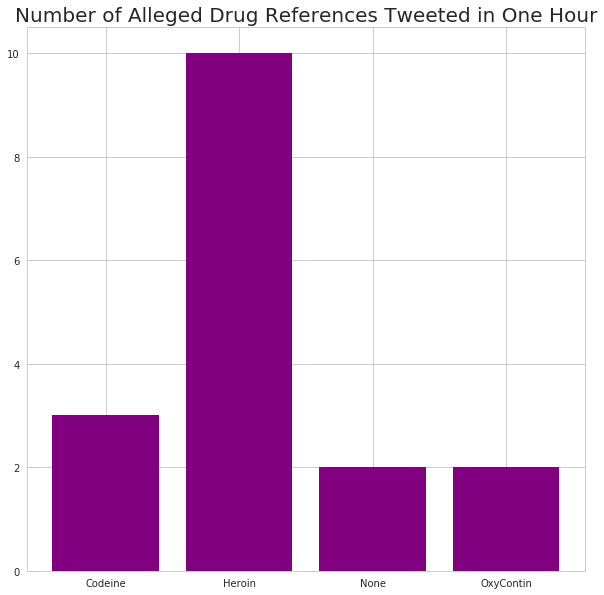

In [98]:
plt.figure(figsize=(10,10))
plt.bar(df["Drug_Referenced"].unique(), df["Drug_Referenced"].value_counts(), color="purple")
plt.title("Number of Alleged Drug References Tweeted in One Hour", size=20)

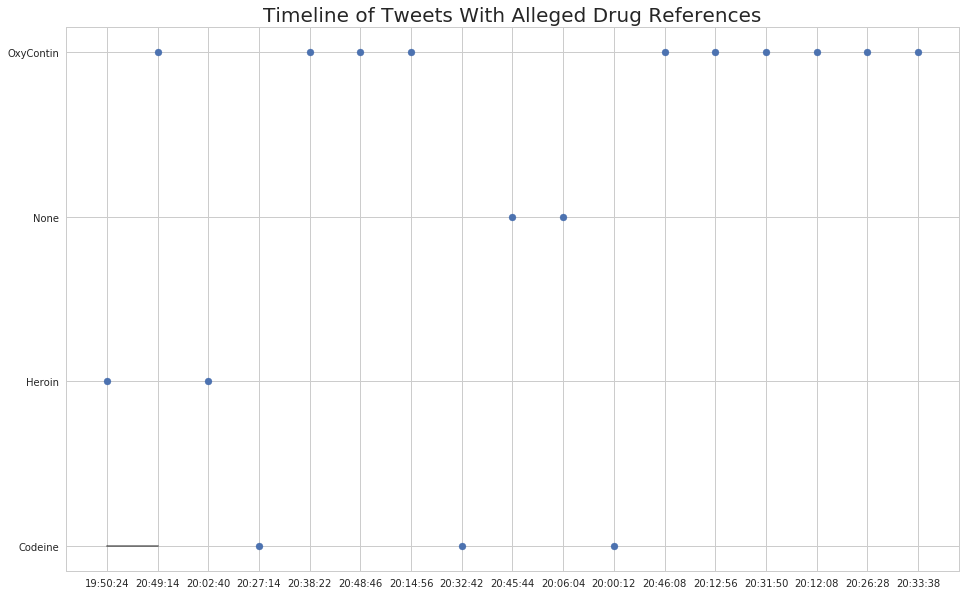

In [101]:
fig, ax = plt.subplots(figsize=(16, 10))

start = min(df["Clock_Time"])
stop = max(df["Clock_Time"])
ax.plot((start, stop), (0, 0), 'k', alpha=.5)

ax.scatter(x=df["Clock_Time"], y=df["Drug_Referenced"])
plt.title("Timeline of Tweets With Alleged Drug References", fontsize=20)

plt.show()

### Conclusions/Findings

+ In filtering tweets from across the United States for certain drug slang, there appeared to be only 17 flagged tweets in one hour. 
+ This number (17 tweets in one hour) is incredibly low.
+ Additionally, when looking deeper at the tweets that registered as "drug references," 59% (10 of 17) of those tweets referenced OxyContin, as determined by the slang "oxy." In fact, "oxy" was used in the word/twitter handle "foxy" or in the word "oxygen."
+ Here are some possibilities for why the number of tweets with drug references is so low:
    + The drug slang words I used/filtered for are outdated. People are in fact referencing drugs in their tweets but using different slang words.
    + The time of day that I streamed the data (Friday from 12PM to 1PM MST) is not a popular time to be talking about drugs. I would argue that late Friday/Saturday night might be a more popular time to talk about drugs. At the same time, I would assume that people might tweet about drugs in preparation for their weekend debauchery.
+ Possible future research using this project: 
    + Figure out the current slang for different hard drugs. 
    + Stream the twitter data at different times over the course of the weekend to find the time that people are most likely to reference drugs.
    + Capture and analyze data on how many people in a given geographical location are retweeting certain drug references in order to draw conclusions about what type of hard drug is being used in certain settings (rural vs urban, etc.).